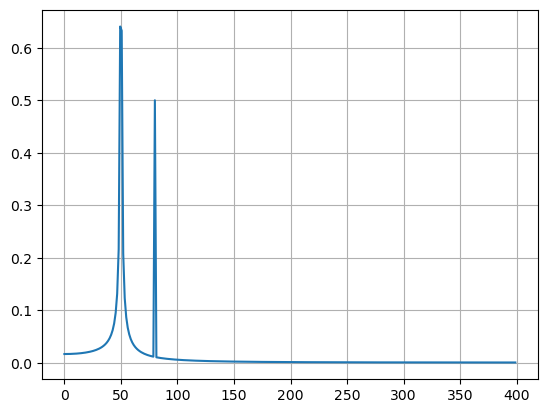

In [3]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

# Number of sample points
N = 600

# sample spacing
T = 1.0 / 800.0

x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

yf = fft(y)
xf = fftfreq(N, T)[:N//2]


plt.plot(xf, 2.0 / N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [ ]:
import numpy as np

def _central_diff(y, t):
    """
    Central difference derivative of y(t) with nonuniform t.
    Returns array of same length as y (forward/backward for endpoints).
    """
    y = np.asarray(y)
    t = np.asarray(t)
    n = len(y)
    dy = np.zeros_like(y, dtype=float)
    if n < 2:
        return dy * np.nan
    # endpoints: forward/backward differences
    dy[0] = (y[1] - y[0]) / (t[1] - t[0])
    dy[-1] = (y[-1] - y[-2]) / (t[-1] - t[-2])
    # interior: central differences using surrounding times
    for i in range(1, n-1):
        dt = t[i+1] - t[i-1]
        if dt == 0:
            dy[i] = 0.0
        else:
            dy[i] = (y[i+1] - y[i-1]) / dt
    return dy

def _time_weighted_variance(x, t):
    """
    Compute time-weighted variance of x(t) over time vector t.
    Interprets x defined at sample times; uses midpoint rule on intervals.
    Returns scalar variance (units of x^2).
    """
    x = np.asarray(x)
    t = np.asarray(t)
    if len(x) < 2:
        return np.nan
    # midpoints and dt
    dt = np.diff(t)
    xm = 0.5 * (x[:-1] + x[1:])
    T = np.sum(dt)
    if T == 0:
        return np.nan
    mean = np.sum(xm * dt) / T
    var = np.sum(((xm - mean)**2) * dt) / T
    return float(var)

def calculate_orbital_stability(time, polar_trajectory, return_dict=False):
    """
    Compute variance of angular acceleration (d^2 theta / dt^2).
    
    Parameters
    ----------
    time : array_like
        1D sequence of time samples (must be same length as theta)
    polar_trajectory : tuple or list-like (radial, angular)
        radial: r(t) (not used here, provided for API consistency)
        angular: theta(t) in radians (can be wrapped; function will unwrap)
    return_dict : bool
        If True, return a dict with intermediate arrays and both raw & normalized metrics.
    
    Returns
    -------
    var_alpha : float
        Time-weighted variance of angular acceleration (rad^2 / s^4 units if theta in rad, time in s).
    (or dict if return_dict=True)
    """
    radial = np.asarray(polar_trajectory[0])
    theta = np.asarray(polar_trajectory[1])
    t = np.asarray(time)
    if len(theta) != len(t):
        raise ValueError("theta and time must have the same length")
    if len(theta) < 3:
        # need at least 3 points to estimate second derivative robustly
        if return_dict:
            return {"var_alpha": np.nan, "alpha": np.array([]), "score": np.nan}
        return np.nan

    # unwrap angles to avoid 2*pi jumps
    th = np.unwrap(theta)

    # first derivative: angular velocity omega = dtheta/dt
    omega = _central_diff(th, t)

    # second derivative: angular acceleration alpha = domega/dt
    alpha = _central_diff(omega, t)

    # time-weighted variance of alpha
    var_alpha = _time_weighted_variance(alpha, t)

    # normalized stability score in [0,1] (1 = stable (small var), 0 = unstable (large var))
    # we normalize by mean(omega)^2 to make it dimensionless (avoid division by zero)
    mean_omega = np.mean(omega)
    denom = mean_omega**2 + 1e-12
    # map var -> score via 1/(1+normalized_variance)
    norm_var = var_alpha / denom
    score = 1.0 / (1.0 + norm_var)

    if return_dict:
        return {
            "alpha": alpha,
            "omega": omega,
            "var_alpha": var_alpha,
            "norm_var_alpha": norm_var,
            "score": float(score)
        }
    return float(var_alpha)

In [168]:
from scipy.signal import welch, find_peaks, windows, detrend

def spectral_concentration_score(r, t, beta=0.05, nperseg=None):
    r = np.asarray(r)
    t = np.asarray(t)
    fs = 1.0 / np.median(np.diff(t))
    r2 = r#detrend(r)
    if nperseg is None:
        nperseg = min(256, len(r2))
    f, P = welch(r2, fs=fs, window='hann', nperseg=nperseg)
    plt.plot(f,P)
    plt.title('spectral')
    plt.show()
    Psum = np.sum(P)
    return Psum
    """
    if Psum <= 0:
        return 0.0
    idx = np.argmax(P)
    f0 = f[idx]
    bw_low = f0 * (1 - beta)
    bw_high = f0 * (1 + beta)
    band_mask = (f >= max(0,bw_low)) & (f <= bw_high)
    power_frac = np.sum(P[band_mask]) / Psum
    return float(power_frac)   # in [0,1]
    """

In [169]:
from scipy.interpolate import interp1d
from PIL import Image
import io

def save_graph_and_close():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    graph = Image.open(buf)
    plt.close()
    return graph

def compute_fft(time, radial):
    time = np.asarray(time)
    radial = np.asarray(radial)
    
    results = dict()
    
    # calculate stability
    # stab = spectral_concentration_score(radial, time)
    stab = calculate_orbital_stability(time, [radial])
    
    """
    minima_indices, _ = find_peaks(-radial)  # negative flips minima to peaks
    maxima_indices, _ = find_peaks(radial)
    minima_times = time[minima_indices]
    minima_values = radial[minima_indices]
    maxima_times = time[maxima_indices]
    maxima_values = radial[maxima_indices]
    critical_points = np.array([time[minima_indices | maxima_indices], radial[minima_indices | maxima_indices]])

    # Compute approximate periods (time differences between consecutive minima)
    period_lens = np.diff(minima_times)
    avg_period = np.mean(period_lens)
    period_std_dev = np.std(period_lens)

    print("Average period:", avg_period, "+/-", period_std_dev)

    # You can also plot them if you want
    plt.plot(time, radial, label='Radial position')
    plt.scatter(minima_times, minima_values, color='orange', label='Minima')
    plt.legend()
    plt.show()
    """
    
    # plot starting data
    plt.figure()
    plt.plot(time, radial)
    plt.xlabel('Time')
    plt.ylabel('Radial Distance')
    plt.title(f'Data')
    results['pre'] = save_graph_and_close()
    
    # detrend the data
    y = radial - np.mean(radial)
    
    # interpolate the data to uniform dt
    t_uniform = np.linspace(np.min(time), np.max(time), np.size(time))
    interp_func = interp1d(time, y, kind='cubic')
    y_uniform = interp_func(t_uniform)
    dt = np.mean(np.diff(t_uniform))
    
    # perform FFT
    y_fft = fft(y_uniform)

    # number of samples
    samples = len(y_fft)

    # frequency axis
    freqs = fftfreq(samples, d=dt)
    sortmask=np.argsort(freqs)
    
    freqs = freqs[sortmask]
    y_fft = y_fft[sortmask]
    
    ge_zero_mask = freqs >= 0
    freqs = freqs[ge_zero_mask]
    y_fft = y_fft[ge_zero_mask]
    
    score = np.sum(np.abs(y_fft)) * (np.max(freqs) - np.min(freqs))
    print(score)
    
    plt.figure(figsize=(7,4))
    plt.plot(freqs, np.abs(y_fft))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title(f"Fourier Transform of Radial Position, S={stab:.4e}")
    plt.grid(True)
    results['fft'] = save_graph_and_close()
    
    return results

### Uniform Stable Case (Lowest, Near 0)

In [170]:
radial_pos=np.array([[5.29e-11, 5.29e-11, 5.29e-11, 5.29e-11, 5.29e-11, 5.289999999999999e-11, 5.2899999999973413e-11, 5.2899999999719824e-11, 5.289999999904584e-11, 5.2899999997796087e-11, 5.28999999958277e-11, 5.289999999300002e-11, 5.289999998917059e-11, 5.289999998419584e-11, 5.289999997793806e-11, 5.289999997028217e-11, 5.289999996116759e-11, 5.289999995063784e-11, 5.289999993889987e-11, 5.2899999926362346e-11, 5.289999991360713e-11, 5.289999990127884e-11, 5.289999988994644e-11, 5.28999998800157e-11, 5.289999987171765e-11, 5.289999986514268e-11, 5.2899999860282325e-11, 5.2899999857059946e-11, 5.289999985534643e-11, 5.289999985496092e-11, 5.2899999855915115e-11, 5.289999985719548e-11, 5.28999998588157e-11, 5.289999986069596e-11, 5.2899999862753236e-11, 5.289999986491182e-11, 5.289999986708935e-11, 5.289999986919218e-11, 5.2899999871116155e-11, 5.289999987275406e-11, 5.289999987401327e-11, 5.289999987484802e-11, 5.2899999875306316e-11, 5.2899999875577385e-11, 5.289999987600475e-11, 5.289999987703012e-11, 5.289999987908029e-11, 5.289999988246331e-11, 5.289999988732759e-11, 5.2899999893678385e-11, 5.289999990141505e-11, 5.289999991036183e-11, 5.28999999202814e-11, 5.28999999308672e-11, 5.28999999408741e-11, 5.2899999949976136e-11, 5.289999995889427e-11, 5.289999996971825e-11, 5.2899999981745804e-11, 5.2899999994580144e-11, 5.290000000792483e-11, 5.290000002151796e-11, 5.290000003510601e-11, 5.290000004843437e-11, 5.290000006125017e-11, 5.290000007331913e-11, 5.290000008446012e-11, 5.290000009459588e-11, 5.290000010380191e-11, 5.2900000112316153e-11, 5.290000012047937e-11, 5.290000012862942e-11, 5.2900000137014274e-11, 5.2900000145763357e-11, 5.2900000154903896e-11, 5.290000016439001e-11, 5.2900000174124536e-11, 5.290000018396657e-11, 5.2900000193720865e-11, 5.290000020223265e-11, 5.2900000210668355e-11, 5.2900000218743033e-11, 5.290000022757767e-11, 5.290000023660492e-11, 5.2900000245424125e-11, 5.2900000253700546e-11, 5.290000026112707e-11, 5.290000026740949e-11, 5.2900000272265865e-11, 5.2900000275439964e-11, 5.2900000276732744e-11, 5.2900000276054094e-11, 5.290000027348515e-11, 5.290000026931802e-11, 5.2900000264027805e-11, 5.290000025816704e-11, 5.290000025223911e-11, 5.2900000246621935e-11, 5.2900000241558723e-11, 5.290000023718632e-11, 5.290000023356913e-11, 5.290000023072451e-11, 5.2900000228637335e-11, 5.290000022795886e-11, 5.290000022793263e-11], [0.0, 4.5709565840908357e-07, 5.028052242499919e-06, 5.073761808340828e-05, 0.0005078332764924918, 0.005078789860583328, 0.033078592317969564, 0.07383649980839826, 0.12173945595832007, 0.17473115212782908, 0.23176074318336662, 0.29219194595131487, 0.35559780065603397, 0.4216663371588204, 0.4901452819485468, 0.5608001585897692, 0.6333746032741164, 0.7075495111998448, 0.7829067109069743, 0.8589140640252676, 0.9349522775381844, 1.0103840754389675, 1.0846323290670932, 1.1572245064723738, 1.2277889940964994, 1.2960182890262963, 1.36161836883082, 1.4242508579574853, 1.4834570072831368, 1.5385219190862651, 1.5791425257819725, 1.619732383816372, 1.6638470532062797, 1.7140370666466795, 1.7688055894112389, 1.8273127256250836, 1.8890251961202509, 1.9535722354996883, 2.020672295730845, 2.0900853077098125, 2.1615725834820045, 2.2348566120687967, 2.3095807555089434, 2.3852792253461823, 2.461377571714341, 2.537239032584537, 2.6122430141025093, 2.68585335630041, 2.7576423701451795, 2.827270715521759, 2.8944430326288844, 2.9588544463625595, 3.0201276861416053, 3.077720261693007, 3.1242994954417016, 3.164120223936089, 3.20189186253784, 3.247880502589437, 3.299436956926098, 3.355297251303575, 3.4147276090967553, 3.477249322747796, 3.5425218177279922, 3.6102791292528957, 3.6802854795265016, 3.7522956141017825, 3.8260141929844362, 3.9010567678787496, 3.9769258941342374, 4.053023497178312, 4.128708994584555, 4.203379660398109, 4.276528822321785, 4.347756436769687, 4.416740184129794, 4.48318766970435, 4.546781103612565, 4.607109388729472, 4.663558787950962, 4.707694592960023, 4.751801790970031, 4.7940585174974295, 4.842944987764339, 4.896692712733651, 4.954347075787226, 5.0153178826505656, 5.079203147975567, 5.145704563544826, 5.214575759988981, 5.285581348351101, 5.3584570634719055, 5.432868978012786, 5.508379380690835, 5.584437820520707, 5.660416122610269, 5.7356822913514005, 5.80967544451556, 5.881941933578346, 5.952124417933594, 6.019921529821969, 6.0850359816558255, 6.147114937098614, 6.2056679995120785, 6.254094608791819, 6.283185304281992]])
radial_1=radial_pos[0]

In [171]:
time_1=np.array([0.0, 1.105274277769807e-23, 1.2158017055467877e-22, 1.2268544483244859e-21, 1.2279597226022557e-20, 1.2280702500300326e-19, 7.998526470614325e-19, 1.785393986953936e-18, 2.9437052569627915e-18, 4.2250641504700545e-18, 5.604060841839397e-18, 7.065309767573334e-18, 8.598486881662407e-18, 1.0196048630208628e-17, 1.1851894945924015e-17, 1.3560356101406e-17, 1.5315233124435598e-17, 1.7108809942271246e-17, 1.8930975013597186e-17, 2.076886103491787e-17, 2.260749327108052e-17, 2.443146215162082e-17, 2.6226812491309246e-17, 2.7982118292263276e-17, 2.968839380081837e-17, 3.133820348252506e-17, 3.292443776599791e-17, 3.443891460489402e-17, 3.58705412752304e-17, 3.7202031284803265e-17, 3.818425263459774e-17, 3.9165730470387024e-17, 4.0232439553357107e-17, 4.1446052710961845e-17, 4.277037592385937e-17, 4.418510019801054e-17, 4.567733064517087e-17, 4.723810202040068e-17, 4.886060638774642e-17, 5.0539038787137875e-17, 5.226762765519746e-17, 5.403966267340371e-17, 5.584652020341403e-17, 5.767693730739744e-17, 5.9517023574307e-17, 6.13513818618972e-17, 6.316500598042233e-17, 6.494493138288559e-17, 6.668081638977837e-17, 6.836445563122802e-17, 6.998870719766333e-17, 7.15461990959372e-17, 7.302780878335633e-17, 7.442041864369993e-17, 7.554672181052794e-17, 7.650960181122802e-17, 7.742293405779288e-17, 7.853495645092897e-17, 7.978161066148385e-17, 8.11323333230284e-17, 8.256938144440605e-17, 8.40811796991949e-17, 8.565949286888694e-17, 8.729788982627133e-17, 8.899066937670115e-17, 9.073190117655944e-17, 9.251444379506501e-17, 9.432900112958564e-17, 9.616354478364189e-17, 9.800361309185409e-17, 9.983371653315581e-17, 1.0163928097004196e-16, 1.0340805487814655e-16, 1.0513036505496056e-16, 1.0679841769253493e-16, 1.0840514257845538e-16, 1.099428554353336e-16, 1.1140161578193453e-16, 1.12766583227021e-16, 1.1383380338968465e-16, 1.1490033182482267e-16, 1.1592211517231686e-16, 1.1710420818702917e-16, 1.1840384814707687e-16, 1.1979795206801002e-16, 1.2127224883301202e-16, 1.2281701828700386e-16, 1.2442504722641827e-16, 1.2609037834830143e-16, 1.2780731986012132e-16, 1.295694817320141e-16, 1.3136878947671067e-16, 1.331946590725921e-16, 1.350337804101494e-16, 1.368709639869574e-16, 1.3869092791430807e-16, 1.4048010985149114e-16, 1.4222754040865425e-16, 1.4392457895722463e-16, 1.4556393831288031e-16, 1.4713842995137345e-16, 1.486395221590688e-16, 1.500553569631224e-16, 1.5122633036791133e-16, 1.5192975419319306e-16])

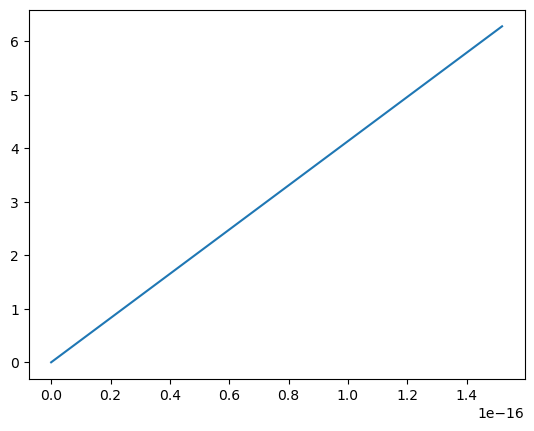

In [172]:
plt.plot(time_1, radial_pos[1])

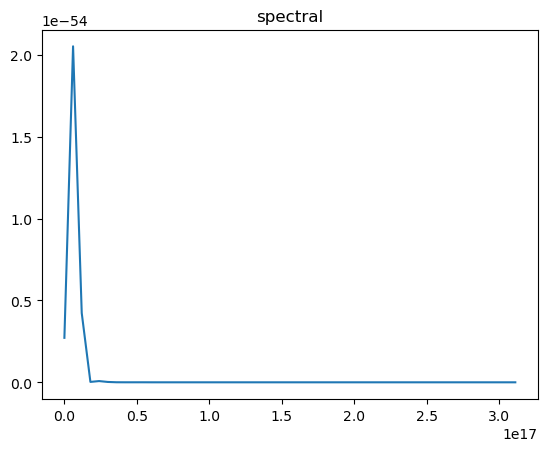

8.436146395093411


In [173]:
res1=compute_fft(time_1, radial_1)

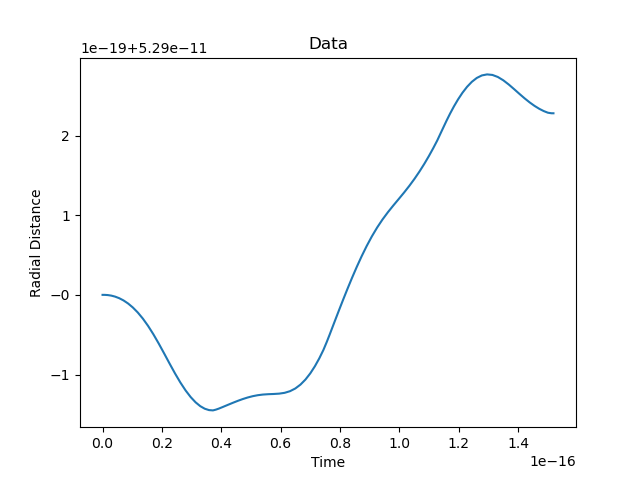

In [174]:
display(res1['pre'])

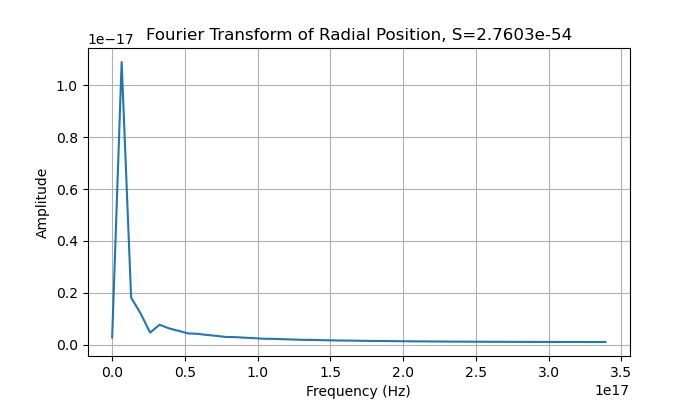

In [175]:
display(res1['fft'])

### Semistable Case (Middle)

In [176]:
radial_2=[5.29e-11, 5.2900000000005215e-11, 5.290000000063084e-11, 5.2900000064236603e-11, 5.290000643523936e-11, 5.290064363250857e-11, 5.291419997687153e-11, 5.296086542565753e-11, 5.3054539420557665e-11, 5.320376638770412e-11, 5.341163148950188e-11, 5.3674869084885824e-11, 5.398303714169753e-11, 5.427055855277692e-11, 5.458900655501393e-11, 5.4938990918816235e-11, 5.537694126076964e-11, 5.5894695890823885e-11, 5.648317597427225e-11, 5.7127899961404764e-11, 5.7806473768346e-11, 5.839962666582074e-11, 5.901633107295512e-11, 5.965618567002054e-11, 6.042041475492224e-11, 6.1284439454744e-11, 6.222903216831273e-11, 6.32313700927886e-11, 6.426013129594471e-11, 6.516438204091502e-11, 6.608121645103638e-11, 6.697029538101411e-11, 6.802051674610929e-11, 6.918883191972018e-11, 7.044696845920687e-11, 7.176625634739471e-11, 7.310958144266051e-11, 7.442325078592443e-11, 7.562030902535328e-11, 7.676078026579411e-11, 7.808804863265632e-11, 7.954282510397655e-11, 8.108808157517647e-11, 8.268841211549573e-11, 8.429749700066616e-11, 8.56406557217561e-11, 8.696124294277659e-11, 8.84212938570964e-11, 9.005591526302107e-11, 9.179670490718044e-11, 9.360051888748127e-11, 9.543105088420833e-11, 9.724123441242644e-11, 9.897318258528737e-11, 1.0079411713300147e-10, 1.0256369679986945e-10, 1.0423419279318204e-10, 1.0555252852511072e-10, 1.0679975821618077e-10, 1.0804911029827349e-10, 1.0932130183336596e-10, 1.1052680335031965e-10, 1.116153781176389e-10, 1.1239741094970391e-10, 1.1312422003871766e-10, 1.1386905917200196e-10, 1.1461910339626314e-10, 1.15314467238345e-10, 1.1591743255214222e-10, 1.1634507322630274e-10, 1.1671381230792394e-10, 1.1702867630945757e-10, 1.173117293314303e-10, 1.1752745269748049e-10, 1.176575592498195e-10, 1.1769932153623765e-10, 1.1767786262552382e-10, 1.176000077006739e-10, 1.1744171962071682e-10, 1.1719061249636472e-10, 1.1684770559155033e-10, 1.1643101662644453e-10, 1.1603158549005247e-10, 1.1559086104606234e-10, 1.1500912629795777e-10, 1.1429954800055678e-10, 1.1348048781164815e-10, 1.1258710531212507e-10, 1.1184601300444947e-10, 1.1108792820575143e-10, 1.1011514113944843e-10, 1.0896324229037549e-10, 1.0766672095626117e-10, 1.0626812046452488e-10, 1.0505062992244814e-10, 1.0377166256720426e-10, 1.0231060138234994e-10, 1.0061312233246005e-10, 9.874893663049667e-11, 9.676962798137401e-11, 9.472181618107917e-11, 9.269186886502464e-11, 9.06599573979751e-11, 8.867104447829958e-11, 8.676653170114142e-11, 8.529413770443455e-11, 8.379590250523088e-11, 8.230433477597198e-11, 8.066388036059371e-11, 7.898526559532133e-11, 7.734418246186613e-11, 7.579179832901936e-11, 7.46010176023471e-11, 7.340745821298814e-11, 7.224182370943625e-11, 7.094613899101002e-11, 6.960199449697762e-11, 6.82731389900676e-11, 6.700612118897488e-11, 6.595777000435464e-11, 6.51034919897098e-11, 6.426082427937223e-11, 6.336492466647947e-11, 6.239393488704935e-11, 6.140705665470763e-11, 6.045003356360327e-11, 5.955647043889309e-11, 5.883162320210353e-11, 5.825902011108762e-11, 5.7707819430624697e-11, 5.712501272720841e-11, 5.651263013045214e-11, 5.591174335868028e-11, 5.5352295515668544e-11, 5.4854666546177046e-11, 5.4431311682833925e-11, 5.415199163869806e-11, 5.39079372651593e-11, 5.364994550283712e-11, 5.340669351549302e-11, 5.320047197340404e-11, 5.304500892060855e-11, 5.2946369693436616e-11, 5.290330145476855e-11, 5.290386997518891e-11, 5.293043325161467e-11, 5.299718535430302e-11, 5.311548352549806e-11, 5.32914715692764e-11, 5.352544704718403e-11, 5.3810967794354404e-11, 5.413393340631419e-11, 5.4411276209351906e-11, 5.469581386298426e-11, 5.507660422631426e-11, 5.554214818502752e-11, 5.6084852796802674e-11, 5.6694166792662606e-11, 5.735320457344015e-11, 5.803634586169148e-11, 5.858524124742479e-11, 5.915312682436301e-11, 5.982546675848495e-11, 6.061487261706356e-11, 6.149956691783811e-11, 6.245999886355378e-11, 6.347175203840946e-11, 6.450086713207414e-11, 6.53656890719001e-11, 6.624136069737857e-11, 6.716734780056003e-11, 6.824351521185391e-11, 6.943175403142594e-11, 7.070443871872916e-11, 7.203183659269239e-11, 7.337424512029215e-11, 7.453356157127555e-11, 7.568935521903e-11, 7.68454823583019e-11, 7.81827544447393e-11, 7.964472567111667e-11, 8.119486660624226e-11, 8.279745304876765e-11, 8.44048840760187e-11, 8.572017489558462e-11, 8.701358084403582e-11, 8.848299218479101e-11, 9.012279886006851e-11, 9.18668048201367e-11, 9.36723530254823e-11, 9.550314953963445e-11, 9.731086531355475e-11, 9.905416547042453e-11, 1.0087404511798686e-10, 1.0264020260535459e-10, 1.043051759111249e-10, 1.0560427020672513e-10, 1.0683374601246792e-10, 1.0808537273017634e-10, 1.0935665962259733e-10, 1.1055942240071357e-10, 1.1164413964848385e-10, 1.1241699536761402e-10, 1.1313564305175838e-10, 1.138811595241705e-10, 1.1463073556419552e-10, 1.1532487124296287e-10, 1.1592615834534323e-10, 1.1635115905507685e-10, 1.167177053477822e-10, 1.1703248168846383e-10, 1.1731487723166227e-10, 1.1752961540314157e-10, 1.1765861194666824e-10, 1.176994397137824e-10, 1.1767734184806913e-10, 1.1759866894878895e-10, 1.174393527950076e-10, 1.171871466617636e-10, 1.1684324443237617e-10, 1.1642588674395143e-10, 1.1597711733688311e-10, 1.1551474583723237e-10, 1.1491365436543716e-10, 1.1418674303238909e-10, 1.1335417323741675e-10, 1.1245442131514215e-10, 1.1167086831586649e-10, 1.108638022317503e-10, 1.0984272960832763e-10, 1.0865146736849462e-10, 1.0732472048111313e-10, 1.0591017407438837e-10, 1.0471415853961054e-10, 1.0353169601102907e-10, 1.0202070062363702e-10, 1.0028893526939067e-10, 9.840054847319332e-11, 9.640545445758915e-11, 9.435128212314952e-11, 9.231473355840903e-11, 9.028760313569434e-11, 8.831101280450009e-11, 8.662469850139153e-11, 8.518145036281312e-11, 8.371358024588542e-11, 8.220952701642018e-11, 8.056399154028306e-11, 7.888582822410983e-11, 7.72487359676233e-11, 7.570306983384031e-11, 7.453058737625817e-11, 7.335552301766748e-11, 7.218131072210866e-11, 7.088152215894789e-11, 6.953679667921556e-11, 6.820998804123604e-11, 6.694692119755287e-11, 6.590668490506678e-11, 6.506665892497112e-11, 6.423794502496043e-11, 6.333919811295916e-11, 6.236706008949538e-11, 6.138044605993811e-11, 6.042475604987014e-11, 5.953329273206141e-11, 5.881213714634167e-11, 5.824551959385024e-11, 5.769993882835599e-11, 5.7116404118849786e-11, 5.650392785150157e-11, 5.590344379790257e-11, 5.534475338662315e-11, 5.484810806321592e-11, 5.442587261704818e-11, 5.414581205398896e-11, 5.390391950707643e-11, 5.364594763832474e-11, 5.3403129633805025e-11, 5.3197618301364046e-11, 5.304301899345033e-11, 5.29452791698997e-11, 5.2903034500231556e-11, 5.290424617529893e-11, 5.2931839872583225e-11, 5.3000058596402565e-11, 5.3120095319281076e-11, 5.3297924733332555e-11, 5.3533646335695425e-11, 5.3820594802687764e-11, 5.414440363114584e-11, 5.442567882232502e-11, 5.4715036141418465e-11, 5.5100874440166944e-11, 5.557101582309193e-11, 5.611783853666152e-11, 5.673050420648583e-11, 5.739169495973759e-11, 5.807520440757378e-11, 5.861368905791275e-11, 5.917026163082179e-11, 5.984644111575865e-11, 6.063882284022776e-11, 6.152595352622659e-11, 6.248821864263128e-11, 6.350099122667925e-11, 6.452997415541512e-11, 6.538916648121157e-11, 6.625898687418071e-11, 6.718877231075455e-11, 6.826763249062189e-11, 6.945793984309602e-11, 7.07321140815746e-11, 7.206029086863723e-11, 7.340247229679373e-11, 7.455692525998379e-11, 7.570782594419994e-11, 7.686792582374794e-11, 7.820779602422196e-11, 7.967163581493472e-11, 8.122303762577633e-11, 8.282618417492083e-11, 8.443312371704863e-11, 8.574057983142948e-11, 8.7026345441151e-11, 8.84980248712093e-11, 9.013907489394754e-11, 9.188385205850156e-11, 9.368981389599957e-11, 9.552066635095635e-11, 9.732775658389767e-11, 9.907363416506956e-11, 1.0089324368899512e-10, 1.0265856957120566e-10, 1.0432220494395546e-10, 1.0561654566598035e-10, 1.0684163691142913e-10, 1.0809376760260266e-10, 1.093648395790796e-10, 1.1056696904617087e-10, 1.1165079611833302e-10, 1.1242149950505031e-10, 1.1313823390801948e-10, 1.1388390055055185e-10, 1.1463337433619596e-10, 1.1532723990059334e-10, 1.1592815752258264e-10, 1.1635257185223791e-10, 1.1671863255570903e-10, 1.170333933729782e-10, 1.1731564945013476e-10, 1.1753017720977882e-10, 1.1765893662631928e-10, 1.1769956540250295e-10, 1.176773327895314e-10, 1.1759848586314426e-10, 1.1743895106240329e-10, 1.1718651204307886e-10, 1.1684240141344368e-10, 1.164249095571235e-10, 1.1597616212963552e-10, 1.155133705762722e-10, 1.1491190518737743e-10, 1.141846636567178e-10, 1.1335184343868852e-10, 1.1245198655266136e-10, 1.1166767087056313e-10, 1.1085937577036509e-10, 1.0983737671450538e-10, 1.0864536143331719e-10, 1.073180531524425e-10, 1.0590325614177696e-10, 1.0470494455823572e-10, 1.0351966207737837e-10, 1.0200632234785755e-10, 1.0027291351222294e-10, 9.838338014199071e-11, 9.638755948174719e-11, 9.433316816196103e-11, 9.229643565559311e-11, 9.026960971814921e-11, 8.829368395471472e-11, 8.660910601663772e-11, 8.51692760741386e-11, 8.370496468705114e-11, 8.21996233545446e-11, 8.055359024356222e-11, 7.887554947987547e-11, 7.723899371777443e-11, 7.569419541839938e-11, 7.452400542740388e-11, 7.33512569975176e-11, 7.217618335340672e-11, 7.087602162215952e-11, 6.953128439027646e-11, 6.82047107119586e-11, 6.694204415757163e-11, 6.590256315776705e-11, 6.506387368999463e-11, 6.423647234675377e-11, 6.33374998911981e-11, 6.236530237396862e-11, 6.137878457954255e-11, 6.042332113181782e-11, 5.953218333555627e-11, 5.881155190240638e-11, 5.824574257126399e-11, 5.770092448539564e-11, 5.711736424356783e-11, 5.6504944443635797e-11, 5.590457989006292e-11, 5.5346054102577225e-11, 5.484960308078319e-11, 5.44275800217099e-11, 5.4147471918288427e-11, 5.3905920219138014e-11, 5.364801066409681e-11, 5.340531602590907e-11, 5.3199968521940836e-11, 5.304555836800941e-11, 5.294802234870607e-11, 5.290598834090645e-11, 5.2907367576140486e-11, 5.2935097102064795e-11, 5.3003475030717346e-11, 5.3123688110572777e-11, 5.330170529013913e-11, 5.3537614572479154e-11, 5.382472909170806e-11, 5.4148643758260267e-11, 5.4430584674988e-11, 5.4721098523437236e-11, 5.510791791862889e-11, 5.557900168157849e-11, 5.612673607956412e-11, 5.6740257060283355e-11, 5.7402217282103864e-11, 5.8086394957800085e-11, 5.862534504410972e-11, 5.918238512830933e-11, 5.98590214895291e-11, 6.065194030661989e-11, 6.153967677926057e-11, 6.250259442361806e-11, 6.351600909137263e-11, 6.454549919490913e-11, 6.54035759993426e-11, 6.627225473096386e-11, 6.720402101466885e-11, 6.82846876291191e-11, 6.947674392994935e-11, 7.075261154681708e-11, 7.208237440587748e-11, 7.342590667796483e-11, 7.457970284206141e-11, 7.573000757882123e-11, 7.689359473083638e-11, 7.823668456751257e-11, 7.970364684622746e-11, 8.125803907535031e-11, 8.286394025416083e-11, 8.447337917479504e-11, 8.578833320639729e-11, 8.708151560113542e-11, 8.854942633279393e-11, 9.018878447332872e-11, 9.193395854131487e-11, 9.374288766977925e-11, 9.558043390036683e-11, 9.740146543104148e-11, 9.918798365404655e-11, 1.010203834972113e-10, 1.0279571951525117e-10, 1.0447178076631897e-10, 1.0579018393592776e-10, 1.0703774701239999e-10, 1.083073198527095e-10, 1.0958850635416642e-10, 1.1079366370831548e-10, 1.118751291675479e-10, 1.1263278519524554e-10, 1.1332495003122973e-10, 1.1408452266753745e-10, 1.1484633467689656e-10, 1.1555212373947426e-10, 1.1616475948494484e-10, 1.165951466198475e-10, 1.169694847567582e-10, 1.1730059418966307e-10, 1.1760128695519146e-10, 1.178363783211225e-10, 1.1798691962799145e-10, 1.1804656960690908e-10, 1.180402845211075e-10, 1.179778027740205e-10, 1.1783826160669888e-10, 1.1760952051758415e-10, 1.1729516939469116e-10, 1.1696871073039893e-10, 1.165839010260464e-10, 1.1615574690020767e-10, 1.1560017190859515e-10, 1.1492397011952317e-10, 1.1413883281424972e-10, 1.1327001439997999e-10, 1.1250597241523434e-10, 1.1168548562416707e-10, 1.1075522200049059e-10, 1.0964406063394525e-10, 1.083949872083945e-10, 1.0706052118858963e-10, 1.0590803509905111e-10, 1.0475198054049684e-10, 1.0329902820009818e-10, 1.016447408274593e-10, 9.984887645342488e-11, 9.796016360826107e-11, 9.602866089126711e-11, 9.412979075579561e-11, 9.223733280049727e-11, 9.038508594473969e-11, 8.859632548780144e-11, 8.689096421844324e-11, 8.553172987913514e-11, 8.415643679324983e-11, 8.272823958711088e-11, 8.13713613323765e-11, 8.030700891757183e-11, 7.945990664409319e-11, 7.861201106355463e-11, 7.765458052124875e-11, 7.65962964790236e-11, 7.548072302208935e-11, 7.433789454155681e-11, 7.319118673977412e-11, 7.206012703936172e-11, 7.096135164802701e-11, 6.990873527142024e-11, 6.891330082015763e-11, 6.798350685242453e-11, 6.712568358576714e-11, 6.634502927286154e-11, 6.564820213095989e-11, 6.510388021641551e-11, 6.468204015782539e-11, 6.428248034422134e-11, 6.38376378648407e-11, 6.33753314687663e-11, 6.292646154870985e-11, 6.251250439457966e-11, 6.214644531650417e-11, 6.183424281287434e-11, 6.157739377226517e-11, 6.137520121265861e-11, 6.124851099614284e-11, 6.115083919658855e-11, 6.107119916927725e-11, 6.102671453070296e-11, 6.102125367270367e-11, 6.105183149315847e-11, 6.111364297084091e-11, 6.12327481735894e-11, 6.139504934508885e-11, 6.15914333065289e-11, 6.181818272409007e-11, 6.207234626185637e-11, 6.235072084093513e-11, 6.26497673136895e-11, 6.296580494200144e-11, 6.329533973476687e-11, 6.363532497787881e-11, 6.398321669919922e-11, 6.433684339693324e-11, 6.469419165767351e-11, 6.505319853667244e-11, 6.54116033998537e-11, 6.576687882683898e-11, 6.611622700500447e-11, 6.64565890119233e-11, 6.67845761788423e-11, 6.709618670052321e-11, 6.734900473931322e-11, 6.755741903996638e-11, 6.776926600186309e-11, 6.800686503536161e-11, 6.827780593514071e-11, 6.857422925504162e-11, 6.889130026423815e-11, 6.922559529364057e-11, 6.957414516484781e-11, 6.993344047294965e-11, 7.029776953899323e-11, 7.065657213721168e-11, 7.094390128526708e-11, 7.118926836786493e-11, 7.142516357562316e-11, 7.170566206504658e-11, 7.201264087935202e-11, 7.233691424098944e-11, 7.267353997644789e-11, 7.301987097035777e-11, 7.337470042882475e-11, 7.373786577360472e-11, 7.411008023060814e-11, 7.449284639336332e-11, 7.488803710951963e-11, 7.529441835064514e-11, 7.568325167627222e-11, 7.609381776025284e-11, 7.653983669623044e-11, 7.697076263351736e-11, 7.739019903091157e-11, 7.779958948912852e-11, 7.820102667428069e-11, 7.859978839121901e-11, 7.900042877145802e-11, 7.940707325794495e-11, 7.982375633645087e-11, 8.025466510369609e-11, 8.07042954791983e-11, 8.117744074644656e-11, 8.167871210440366e-11, 8.22109013710587e-11, 8.277179466029571e-11, 8.335270743050141e-11, 8.394362462276108e-11, 8.453854236722329e-11, 8.513469469760966e-11, 8.572949852309513e-11, 8.631688397717467e-11, 8.682173983466917e-11, 8.731268249321684e-11, 8.793117213149337e-11, 8.863438541080439e-11, 8.939659232178797e-11, 9.020257840682093e-11, 9.103575888961647e-11, 9.187806653096595e-11, 9.271952374683308e-11, 9.355821020944723e-11, 9.439461998609674e-11, 9.522836261600679e-11, 9.605736822295399e-11, 9.687822459766072e-11, 9.76867131118825e-11, 9.84779950710852e-11, 9.924625964923161e-11, 9.998375714193223e-11, 1.0067872591336602e-10, 1.0118209840514271e-10, 1.0168787260579155e-10, 1.0228246074060176e-10, 1.0296170682138342e-10, 1.0370939847099488e-10, 1.0451759136325952e-10, 1.0538201628998709e-10, 1.0630040420882548e-10, 1.072716660628378e-10, 1.0829541583281057e-10, 1.0937164124086308e-10, 1.105004332322202e-10, 1.1168172778461968e-10, 1.1291503381801588e-10, 1.1419913314684453e-10, 1.1553174760786692e-10, 1.1690917555950624e-10, 1.183259028959028e-10, 1.1977418832629399e-10, 1.212436021210077e-10, 1.2272044547541147e-10, 1.241868194386855e-10, 1.256180049574962e-10, 1.2698378990973145e-10, 1.280020493529143e-10, 1.2898690753375795e-10, 1.3018077499482575e-10, 1.3154366714553483e-10, 1.3232321480454566e-10]

In [177]:
time_2=[0.0, 9.150587271660835e-24, 1.0065645998826918e-22, 1.0157151871543527e-21, 1.0166302458815189e-20, 1.0167217517542356e-19, 4.776163547011412e-19, 9.89237438736961e-19, 1.577596378959812e-18, 2.214733160934267e-18, 2.87959747137035e-18, 3.552081202653318e-18, 4.210948496707442e-18, 4.74916780439807e-18, 5.287069437402487e-18, 5.827206229562335e-18, 6.447710345440756e-18, 7.122456761439782e-18, 7.831952963827539e-18, 8.556626358286193e-18, 9.273951253845757e-18, 9.870925280080253e-18, 1.046751239503831e-17, 1.1064966205724347e-17, 1.1754756199334178e-17, 1.2508988643316122e-17, 1.3308303393523033e-17, 1.4133266756123384e-17, 1.4960054822285917e-17, 1.5673335254292087e-17, 1.6386126470266082e-17, 1.7069167101420334e-17, 1.786772394818341e-17, 1.8747987531859674e-17, 1.968915769573167e-17, 2.0671366749730705e-17, 2.1669221946978357e-17, 2.2645206677147977e-17, 2.3536459411387275e-17, 2.4388635026762956e-17, 2.538571598133141e-17, 2.648714971671302e-17, 2.7669314623808786e-17, 2.890962977909027e-17, 3.0176072731483347e-17, 3.1250257006547535e-17, 3.232340070614e-17, 3.353173454446976e-17, 3.491495892263312e-17, 3.6427778261298e-17, 3.8044402689860183e-17, 3.974315414735703e-17, 4.148910384036607e-17, 4.3230416065937403e-17, 4.5147912947780935e-17, 4.711123124980452e-17, 4.9071912583738493e-17, 5.0706506372192665e-17, 5.2336741139838704e-17, 5.406645046935755e-17, 5.594766782385116e-17, 5.786794467716611e-17, 5.974697080156104e-17, 6.120374672827074e-17, 6.265804217190524e-17, 6.427473741702865e-17, 6.60718336232539e-17, 6.794715818169343e-17, 6.981131848340483e-17, 7.133525561192721e-17, 7.285807379937131e-17, 7.440603308401172e-17, 7.615481125944051e-17, 7.800615234521194e-17, 7.98714700610839e-17, 8.145692550857213e-17, 8.304203427451902e-17, 8.453273374613647e-17, 8.624375678227575e-17, 8.807526344090345e-17, 8.994200753890172e-17, 9.175314820190837e-17, 9.322432387447732e-17, 9.465445175289477e-17, 9.632874000951707e-17, 9.814063159160384e-17, 1.0000924009142922e-16, 1.0184951600420947e-16, 1.0325634749895411e-16, 1.0460552369841783e-16, 1.0622748028967129e-16, 1.0801813406042921e-16, 1.0989692888093282e-16, 1.117916253479952e-16, 1.1334838323528934e-16, 1.1490514112258347e-16, 1.1659889757592795e-16, 1.184696901737727e-16, 1.2042193508601282e-16, 1.2239525395985664e-16, 1.2434511719069765e-16, 1.2619922065909543e-16, 1.279876278049135e-16, 1.2968171785317348e-16, 1.312585827155561e-16, 1.324510901650112e-16, 1.336435976144663e-16, 1.3481230813160984e-16, 1.3607923609801522e-16, 1.373588065039753e-16, 1.385965232485558e-16, 1.397582476954337e-16, 1.406452187069484e-16, 1.4153218971846312e-16, 1.4239786746758565e-16, 1.4336141524524662e-16, 1.4436492138270489e-16, 1.4536392622569102e-16, 1.4632608058978808e-16, 1.4713193472908111e-16, 1.4779697702892358e-16, 1.4846201932876605e-16, 1.491809785269722e-16, 1.4997709391483528e-16, 1.50808503841069e-16, 1.5164159370151835e-16, 1.5244947790526485e-16, 1.5313148443588482e-16, 1.536909911810176e-16, 1.5425049792615038e-16, 1.548691421076196e-16, 1.555564779609861e-16, 1.5627883791405076e-16, 1.570084821925529e-16, 1.5772146946392167e-16, 1.5839547762207235e-16, 1.5888831300616327e-16, 1.5936300840018012e-16, 1.5992891098847515e-16, 1.605570833839093e-16, 1.61219999066534e-16, 1.6189457791474354e-16, 1.6255929649927199e-16, 1.6319235266378788e-16, 1.6367193899488353e-16, 1.6412193832735837e-16, 1.6467304392961243e-16, 1.6528650613090247e-16, 1.65938794244721e-16, 1.6660966466956653e-16, 1.6727870022939537e-16, 1.6792339519256874e-16, 1.6841588697633301e-16, 1.6887948661583667e-16, 1.6945064800077778e-16, 1.7009170662965073e-16, 1.7078021163832134e-16, 1.7149708205809455e-16, 1.7222201497639126e-16, 1.729309162763729e-16, 1.7347548599560879e-16, 1.7401957798841632e-16, 1.7464245639679236e-16, 1.753493128827337e-16, 1.7611577860542592e-16, 1.7692295715817415e-16, 1.7775072499974692e-16, 1.785736909635271e-16, 1.792532921321132e-16, 1.799323291376124e-16, 1.8064224869364338e-16, 1.814589493351984e-16, 1.823527984831336e-16, 1.8330376277412762e-16, 1.8429137043247794e-16, 1.8528839422004873e-16, 1.8614986149207378e-16, 1.8701057944928471e-16, 1.878747030999758e-16, 1.888797494025784e-16, 1.8998731655498602e-16, 1.9117416361006512e-16, 1.924174304257033e-16, 1.9368398175703766e-16, 1.9473700616882888e-16, 1.9578893005877124e-16, 1.9700596378168692e-16, 1.9839492011495486e-16, 1.9991225587649499e-16, 2.0153253462902855e-16, 2.0323400181739535e-16, 2.049803323818426e-16, 2.067363313112983e-16, 2.0865696732418043e-16, 2.1062123081929758e-16, 2.1258045842968462e-16, 2.1419504893936585e-16, 2.1580506476311114e-16, 2.1754090966587292e-16, 2.1942455806656862e-16, 2.2134470084585535e-16, 2.232214446774176e-16, 2.2466419475751226e-16, 2.2610441747311114e-16, 2.277248741383822e-16, 2.2952396770633427e-16, 2.3139979524725663e-16, 2.332630775043388e-16, 2.347811915951765e-16, 2.362981793146303e-16, 2.378493809785358e-16, 2.39599994033015e-16, 2.414520497107284e-16, 2.4331698027215275e-16, 2.4489872687465406e-16, 2.464801295377634e-16, 2.4797415856530947e-16, 2.496870891148769e-16, 2.515194911849917e-16, 2.5338613345389274e-16, 2.551960356088868e-16, 2.5683320067983884e-16, 2.5830830094464083e-16, 2.6000807433226096e-16, 2.618331079798136e-16, 2.637032117835257e-16, 2.6553120477471757e-16, 2.6699813604569143e-16, 2.6841194344307656e-16, 2.7008527149241704e-16, 2.7190468263781275e-16, 2.7379449894095176e-16, 2.756802003823135e-16, 2.7718788704570167e-16, 2.7861180336888924e-16, 2.8034797671093747e-16, 2.8223903232414353e-16, 2.841988624517003e-16, 2.861710358715066e-16, 2.8811167605683573e-16, 2.8995859186053154e-16, 2.917314179541525e-16, 2.9340564116661914e-16, 2.9479703678612685e-16, 2.9596411088425907e-16, 2.971311849823913e-16, 2.9830865235772007e-16, 2.9957844859507074e-16, 3.008567683696525e-16, 3.0209080088561395e-16, 3.032470667704186e-16, 3.0412022637075144e-16, 3.0499338597108426e-16, 3.058654481017117e-16, 3.0683216877649513e-16, 3.078363743406761e-16, 3.088342560158683e-16, 3.0979395163939804e-16, 3.105941002675071e-16, 3.1124847178558765e-16, 3.119028433036682e-16, 3.126244554824805e-16, 3.134220410531656e-16, 3.142539085097562e-16, 3.150866415864598e-16, 3.1589351091765655e-16, 3.165728273861519e-16, 3.171270604617512e-16, 3.1768129134635313e-16, 3.1830114486545613e-16, 3.189891949217533e-16, 3.197118424485976e-16, 3.2044141006375803e-16, 3.2115400079996626e-16, 3.2182728289786135e-16, 3.223223923138307e-16, 3.2279387907070396e-16, 3.233609865932405e-16, 3.239898966598317e-16, 3.246531673966004e-16, 3.253277553048424e-16, 3.259921506924009e-16, 3.266245181016621e-16, 3.2710637323172166e-16, 3.2756054022332016e-16, 3.2811404462099807e-16, 3.2872904392831214e-16, 3.29382215376331e-16, 3.3005334290215887e-16, 3.307219763973763e-16, 3.313654937676296e-16, 3.318628897904647e-16, 3.323321759598581e-16, 3.3290809676419597e-16, 3.3355239021111794e-16, 3.3424301700745215e-16, 3.349609150797225e-16, 3.3568563126625003e-16, 3.363927665673138e-16, 3.369258050846339e-16, 3.3745834627988335e-16, 3.380841815845265e-16, 3.387930195115083e-16, 3.3956089965869674e-16, 3.4036895870501884e-16, 3.411969745562427e-16, 3.4201935124161313e-16, 3.426942318621683e-16, 3.4336853780985077e-16, 3.4408121099417284e-16, 3.448997878633718e-16, 3.457950445352311e-16, 3.4674701046217986e-16, 3.477351348328713e-16, 3.4873197911883807e-16, 3.495898585177678e-16, 3.5044697767665466e-16, 3.513141379284551e-16, 3.5232125723305494e-16, 3.5343042274273273e-16, 3.5461848633154224e-16, 3.558625065693225e-16, 3.5712904323918236e-16, 3.581760875310975e-16, 3.5922201461827744e-16, 3.604411592992834e-16, 3.6183149612614985e-16, 3.6334992167169274e-16, 3.649710822850616e-16, 3.6667320181137385e-16, 3.6841959813145264e-16, 3.701789849845365e-16, 3.7210035822804664e-16, 3.740648364206069e-16, 3.7602369668310107e-16, 3.7763329564458804e-16, 3.7923826705979544e-16, 3.809754992553114e-16, 3.828596962440561e-16, 3.847797996501982e-16, 3.866560075890525e-16, 3.880954381288562e-16, 3.895323302899314e-16, 3.9115361680934305e-16, 3.929531502138266e-16, 3.9482908537749934e-16, 3.9669216752549904e-16, 3.982089682846149e-16, 3.9972464099327017e-16, 4.0127655290830623e-16, 4.030275675206842e-16, 4.048797799801564e-16, 4.0674462820919595e-16, 4.0832557095061075e-16, 4.0990617033070355e-16, 4.1140091765550014e-16, 4.131142611834264e-16, 4.149468553418556e-16, 4.1681346818334497e-16, 4.1862308546111274e-16, 4.2025958357865796e-16, 4.217355499167942e-16, 4.234358147127343e-16, 4.2526109571335457e-16, 4.271312155206157e-16, 4.2895895086452343e-16, 4.304269343205754e-16, 4.3184246852629495e-16, 4.335167503433179e-16, 4.3533668861419074e-16, 4.3722667907379547e-16, 4.391121355166212e-16, 4.4062222823479153e-16, 4.420489881322009e-16, 4.43787098034575e-16, 4.45679099217623e-16, 4.476392637858922e-16, 4.496113467912869e-16, 4.515514674805511e-16, 4.533979285607369e-16, 4.551699600316313e-16, 4.568431905874078e-16, 4.582328590727685e-16, 4.593969850454418e-16, 4.605611110181152e-16, 4.61739497003084e-16, 4.6300958825188e-16, 4.642877445042913e-16, 4.655213292255547e-16, 4.666769294948317e-16, 4.675483868111331e-16, 4.684198441274345e-16, 4.692925742820592e-16, 4.702596162911388e-16, 4.712638923912584e-16, 4.722616765336648e-16, 4.732211614103825e-16, 4.740208181133789e-16, 4.746742231611101e-16, 4.753276282088413e-16, 4.760495018193887e-16, 4.768472416765457e-16, 4.776791566771538e-16, 4.785118399691279e-16, 4.79318574740169e-16, 4.799975404456541e-16, 4.80551093807489e-16, 4.811046446556002e-16, 4.817246291172614e-16, 4.824127513684563e-16, 4.831354210992354e-16, 4.83864967444384e-16, 4.845774960946275e-16, 4.852506709821851e-16, 4.857460711446625e-16, 4.862171104954119e-16, 4.867843669706673e-16, 4.874133722881143e-16, 4.880767069737475e-16, 4.887513457593637e-16, 4.894157939361105e-16, 4.900482293466427e-16, 4.905299460352894e-16, 4.909838497578526e-16, 4.915372043736615e-16, 4.921520982726491e-16, 4.92805178483514e-16, 4.934762036074498e-16, 4.941446942368785e-16, 4.947879849968406e-16, 4.952862104269512e-16, 4.957569662123514e-16, 4.963337781547761e-16, 4.969786984345849e-16, 4.976697679938225e-16, 4.9838795053409e-16, 4.991128115384439e-16, 4.998199830628601e-16, 5.003530046926162e-16, 5.008855279862344e-16, 5.015112530980372e-16, 5.022199822270156e-16, 5.029877595978003e-16, 5.037957131297043e-16, 5.046235859335804e-16, 5.054457024446338e-16, 5.061191654947096e-16, 5.067920515820261e-16, 5.075056618521375e-16, 5.08324910022875e-16, 5.092206827312853e-16, 5.101730251459658e-16, 5.111613637159246e-16, 5.121581892391057e-16, 5.130146593690672e-16, 5.138703672112791e-16, 5.147391035992512e-16, 5.157473902913481e-16, 5.168574674118685e-16, 5.180461685307964e-16, 5.1929047904694e-16, 5.205569662990027e-16, 5.216082539679832e-16, 5.226584123206388e-16, 5.238721956061743e-16, 5.252582150098566e-16, 5.267734369499756e-16, 5.283930146389085e-16, 5.300964181270116e-16, 5.318508323248072e-16, 5.336459186607587e-16, 5.355755031238804e-16, 5.375452347957503e-16, 5.395122668276715e-16, 5.411464296703259e-16, 5.427760109302916e-16, 5.445326313556449e-16, 5.464264508746301e-16, 5.483447910015372e-16, 5.502082120912946e-16, 5.516137848844076e-16, 5.529872693893462e-16, 5.546169644604872e-16, 5.564183892191242e-16, 5.582918662843447e-16, 5.601485554500881e-16, 5.616427953235514e-16, 5.631358838594939e-16, 5.646927831482459e-16, 5.66446714488095e-16, 5.683048337954806e-16, 5.701840155806502e-16, 5.718152087554057e-16, 5.734460101194764e-16, 5.749221736566931e-16, 5.7662960858107e-16, 5.784535911039414e-16, 5.802948372999193e-16, 5.818312524374397e-16, 5.833676675749601e-16, 5.848551957026209e-16, 5.865532103948659e-16, 5.883773163810874e-16, 5.902623525053404e-16, 5.921390894696613e-16, 5.936527874444539e-16, 5.951664854192465e-16, 5.967693715093364e-16, 5.985559383562918e-16, 6.00429436315036e-16, 6.023028960681746e-16, 6.038324964335217e-16, 6.052969687383654e-16, 6.070523714565339e-16, 6.08952441355256e-16, 6.109146617559766e-16, 6.128830791404956e-16, 6.148106530468935e-16, 6.166341081039616e-16, 6.183912360106717e-16, 6.200613802715563e-16, 6.216346057940712e-16, 6.231037946256254e-16, 6.242567056695109e-16, 6.254096167133964e-16, 6.265950761863446e-16, 6.2771280649182e-16, 6.285854675172074e-16, 6.292783992527212e-16, 6.29971330988235e-16, 6.307539644228263e-16, 6.316206712737061e-16, 6.325380959178171e-16, 6.334844817703509e-16, 6.344438100428932e-16, 6.354032422187649e-16, 6.363520700570377e-16, 6.372813651161533e-16, 6.381838628032529e-16, 6.390535681516094e-16, 6.398852445584463e-16, 6.406733064842443e-16, 6.414087734801612e-16, 6.420097822675022e-16, 6.424952997234217e-16, 6.429744575385189e-16, 6.435348883377879e-16, 6.441553819228474e-16, 6.448070232096783e-16, 6.454676460804356e-16, 6.461213894248695e-16, 6.467583099956715e-16, 6.473720669100799e-16, 6.47956339259997e-16, 6.484079339068017e-16, 6.488480112125252e-16, 6.493531401696688e-16, 6.498731719424612e-16, 6.503816398697954e-16, 6.508632089769697e-16, 6.513187290888639e-16, 6.518716318408956e-16, 6.524063473920436e-16, 6.529103874223901e-16, 6.533900273154335e-16, 6.538492943867933e-16, 6.542898994673089e-16, 6.547123621041106e-16, 6.551167876390712e-16, 6.555033847542157e-16, 6.558726812102875e-16, 6.562254644886963e-16, 6.565625860216846e-16, 6.568847639346859e-16, 6.571924511198426e-16, 6.574857822751752e-16, 6.577645875700629e-16, 6.580284436314089e-16, 6.582767155785374e-16, 6.585085301835463e-16, 6.587226013162397e-16, 6.588922001614888e-16, 6.590294344250438e-16, 6.591666686885988e-16, 6.593180097411535e-16, 6.594874410732373e-16, 6.596691848804737e-16, 6.598596498751229e-16, 6.60056325371651e-16, 6.602571497082666e-16, 6.60459920556446e-16, 6.60661404326934e-16, 6.608560132333931e-16, 6.610092718855755e-16, 6.611384135579045e-16, 6.612611219904692e-16, 6.614052543357979e-16, 6.615608674645809e-16, 6.617229372218146e-16, 6.61888779876048e-16, 6.620569646338729e-16, 6.622268242356167e-16, 6.623982174542355e-16, 6.625714151639287e-16, 6.627470324060054e-16, 6.629258157434089e-16, 6.631070927211901e-16, 6.632782065880892e-16, 6.634565084755459e-16, 6.63647556258697e-16, 6.638296266268751e-16, 6.640045678840963e-16, 6.641732384594854e-16, 6.643367093170572e-16, 6.644972715924305e-16, 6.646568262804398e-16, 6.648170238735576e-16, 6.649794090468129e-16, 6.651455183312882e-16, 6.653169368964703e-16, 6.654952870925362e-16, 6.656820425676249e-16, 6.658779305851369e-16, 6.660818203049796e-16, 6.662903165043419e-16, 6.66499719300855e-16, 6.667079067980219e-16, 6.669139734275272e-16, 6.671171189460908e-16, 6.673154095423752e-16, 6.674840576706436e-16, 6.676465272813087e-16, 6.678491257198941e-16, 6.680767581058026e-16, 6.683203523011283e-16, 6.685745489968026e-16, 6.688338350951063e-16, 6.690925377029378e-16, 6.693477181791468e-16, 6.695989840607596e-16, 6.698466713779384e-16, 6.700908414447068e-16, 6.703310657813495e-16, 6.705665454023924e-16, 6.70796276924812e-16, 6.710191097679606e-16, 6.712336495843577e-16, 6.714379954467238e-16, 6.716291826892504e-16, 6.717668593228772e-16, 6.719045359565041e-16, 6.720655715603354e-16, 6.722484899053569e-16, 6.724485972493204e-16, 6.72663488236026e-16, 6.728917772057042e-16, 6.731326326213921e-16, 6.733855485176536e-16, 6.73650212155211e-16, 6.73926414170917e-16, 6.742139770622741e-16, 6.745126896701385e-16, 6.748222409714726e-16, 6.751421498276243e-16, 6.754716897248733e-16, 6.758098092428392e-16, 6.761550495442891e-16, 6.765054586525352e-16, 6.768584971799929e-16, 6.772109178315187e-16, 6.775585641785663e-16, 6.778957760659809e-16, 6.782157306404108e-16, 6.784531404649343e-16, 6.786818714954444e-16, 6.789580034577246e-16, 6.792717489729221e-16, 6.794505163616267e-16]

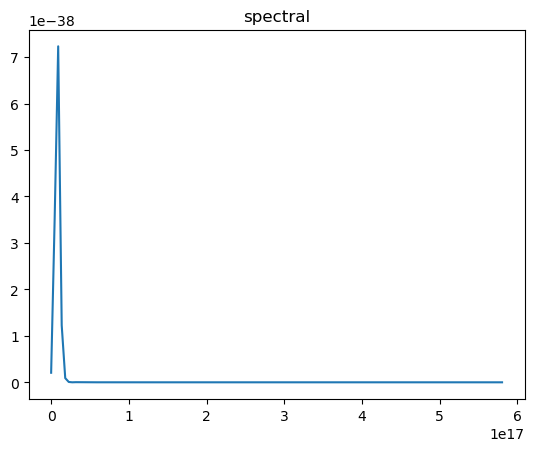

28477857058.113113


In [178]:
res2=compute_fft(time_2, radial_2)

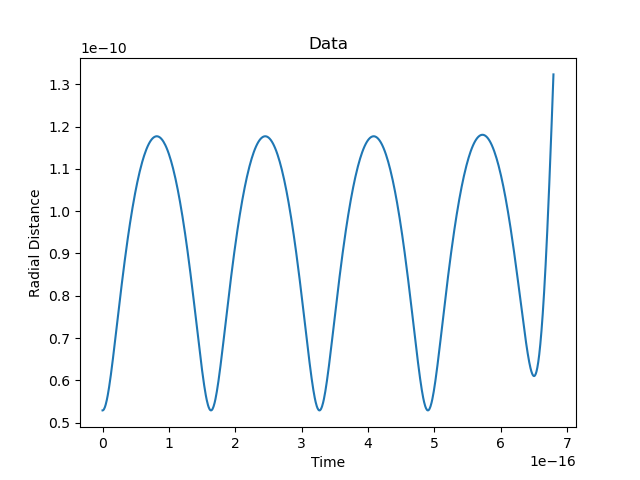

In [179]:
display(res2['pre'])

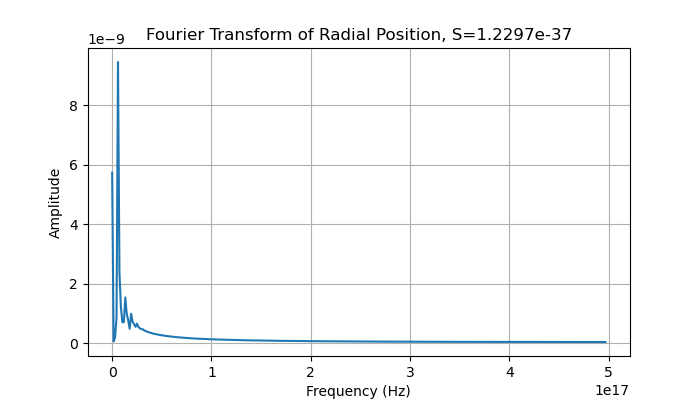

In [180]:
display(res2['fft'])

### Unstable Case (HIGHEST)

In [181]:
time_3 = np.linspace(0, 1e-3, 200)
radial_3 = 5.29e-11 * (1 + time_3)

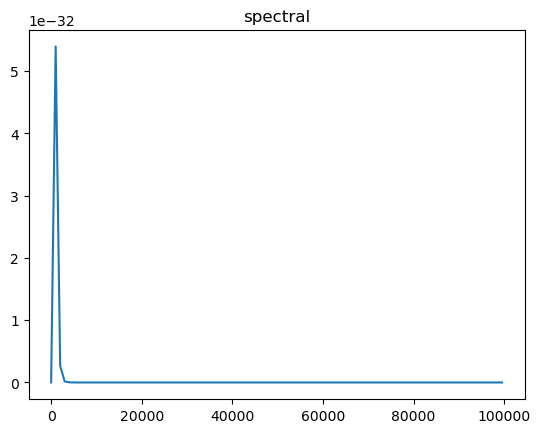

9.028739033464387e-07


In [182]:
res3=compute_fft(time_3, radial_3)

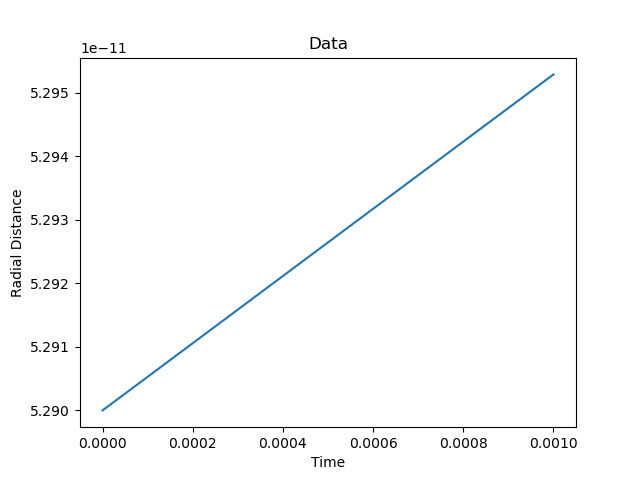

In [183]:
display(res3['pre'])

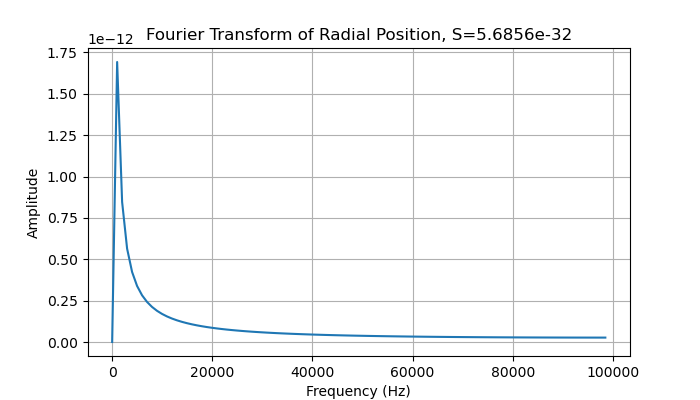

In [184]:
display(res3['fft'])